In [171]:
# Run these before executing
# module load anaconda3/5.0.1
# source activate fair_env_latest_py3_theano
# module load cuda/9.0
# module load NCCL/2.3.7-1-cuda.9.0


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import BVH
import Animation
from Quaternions import Quaternions

from collections import defaultdict
from itertools import product
from sklearn import model_selection
import numpy as np
import os
import random

In [172]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [173]:
ANGLES = [45, 90, 135, 180]
FREQUENCIES = [30, 60, 90, 120]
TYPES = ["sinusoidal", "sinusoidal_x"] #'pendulum'
NUM_JOINTS = 4
NUM_COORDINATES = 3
NUM_PREDICTIONS = 2 * NUM_JOINTS * NUM_COORDINATES
BASE_PATH = "/checkpoint/dgopinath/natural_gesture_generation/data/"
BATCH_SIZE = 64
HIDDEN_DIM = 128
SUBSAMPLED_FRAMERATE = 30
ACTION_TIME = 2

In [174]:
def positions_wrt_base(anim):

    # global transforms for each frame F and joint J
    globals = Animation.transforms_global(anim)  # (F, J, 4, 4) ndarray
    transforms_wrt_root = Animation.transforms_blank(anim)

    for i in range(1, anim.shape[1]):  # modifies all joints except root/base
        transforms_wrt_root[:, i] = Animation.transforms_multiply(Animation.transforms_inv(globals[:, 0]), globals[:, i])
    transforms_wrt_root[:, 0] = globals[:, 0]  # root/base joint retains global position

    positions_wrt_root = transforms_wrt_root[:, :, 0:3, 3]
    rotations_wrt_root = Quaternions.from_transforms(transforms_wrt_root).angle_axis()

    return rotations_wrt_root, positions_wrt_root

In [208]:
# CHANGED FORMAT TO (ALL_ROTATIONS, ALL_POSITIONS)

def extract_sequences(joint_rotations, joint_positions, frametime,
                      stride=0.25, downsampled_hertz=30, window_length=5.0):

    # initialize data structs, using CNN-like computation of size of input
    J_p, J_r = joint_positions.shape[1], joint_rotations.shape[1],  # num of joints
    animation_time = len(joint_rotations) * frametime
    n = int(np.trunc((animation_time - window_length) / stride)) + 1  # sample size
    num_joint_coordinates = joint_rotations.shape[2] + joint_positions.shape[2]
    num_posture_dimensions = (J_p * joint_positions.shape[2]) + (J_r * joint_rotations.shape[2])  #J * num_joint_coordinates
    T = int(np.trunc(downsampled_hertz * window_length))

    datapoint_size = num_posture_dimensions * T
    datapoints = np.zeros((n, datapoint_size), dtype=float)
    datapoints_temporal = np.zeros((n, T, num_posture_dimensions), dtype=float)


    current_frame_iterator = 0
    input_hertz = int(np.trunc(1.0 / frametime))
    step_size = int(np.trunc(input_hertz / downsampled_hertz))
    sample_joint_positions = np.zeros((n, T, J_p, joint_positions.shape[2]))
    sample_joint_rotations = np.zeros((n, T, J_r, joint_rotations.shape[2]))

    for i in range(n):
        # retrieve downsampled set of frames, for extracting character body posture over duration of sequence
        posture_sequence_concatenated = []
        posture_sequence_by_time = np.zeros((T, num_posture_dimensions))
        for t in range(current_frame_iterator, (T * step_size + current_frame_iterator), step_size):

            # get posture information for given (target) frame
            posture = []
            t_downsampled = int((t - current_frame_iterator)/float(step_size))

            if J_p == J_r:
                J = J_p
                for j in range(J):  # all joints
                    # rotation data
                    sample_joint_rotations[i][t_downsampled][j] = joint_rotations[t][j]
                    posture.extend(joint_rotations[t][j])
                for j in range(J):  # all joints
                    # position data
                    sample_joint_positions[i][t_downsampled][j] = joint_positions[t][j]
                    posture.extend(joint_positions[t][j])
            else:
                joints_pos, joints_rot = set(list(range(J_p))), set(list(range(J_r)))
                J = joints_pos | joints_rot  # union of sets
                for j in J:
                    if j in joints_pos:  # joints considered for position data
                        sample_joint_positions[i][t_downsampled][j] = joint_positions[t][j]
                        posture.extend(joint_positions[t][j])
                    if j in joints_rot:  # joints considered for rotation data
                        sample_joint_rotations[i][t_downsampled][j] = joint_rotations[t][j]
                        posture.extend(joint_rotations[t][j])

            posture_sequence_concatenated.extend(posture)
            posture_sequence_by_time[t_downsampled] = posture


        # update datapoints struct with current iteration input
        datapoints[i] = posture_sequence_concatenated
        datapoints_temporal[i] = posture_sequence_by_time
        current_frame_iterator += int(np.trunc(stride * input_hertz))

    return datapoints, datapoints_temporal, sample_joint_rotations, sample_joint_positions

In [209]:
dataset = defaultdict(list)
for angle, freq, motion_type in product(ANGLES, FREQUENCIES, TYPES):
    filename = os.path.join(BASE_PATH, motion_type, "source", f"{angle}_{freq}.bvh")
    anim, joint_names, frametime = BVH.load(filename)
    joint_rotations_root, joint_positions_root = positions_wrt_base(anim)
    _, input_data, _, _ = extract_sequences(joint_rotations_root[1], joint_positions_root, frametime)
    # input_data is of shape [num_sequences, seq_len, NUM_PREDICTIONS]
    train, test = model_selection.train_test_split(input_data, train_size=0.8)
    dataset["train"].extend(train)
    dataset["test"].extend(test)

/private/home/dgopinath/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [210]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        # self.batch_size = batch_size

    def forward(self, batch):
        lstm_out, (lstm_hidden, lstm_cell) = self.lstm(batch) # batch.view(-1, , NUM_PREDICTIONS))
        return lstm_hidden, lstm_cell

In [211]:
class LSTMDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        output = output.squeeze(0)
        output = self.out(output)
        return output, hidden, cell


In [218]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = 'cuda'
                
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        teacher_forcing_ratio = 0.5
        max_len = trg.shape[0]
        batch_size = trg.shape[1]
        outputs = torch.zeros(max_len, batch_size, NUM_PREDICTIONS).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0,:]
        for t in range(1, max_len):
            input = input.unsqueeze(0)
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output
        return outputs

In [219]:
enc = LSTMEncoder(NUM_PREDICTIONS, HIDDEN_DIM)
dec = LSTMDecoder(NUM_PREDICTIONS, HIDDEN_DIM, NUM_PREDICTIONS)
model = Seq2Seq(enc, dec).to('cuda')
model.zero_grad()
model.double()

Seq2Seq(
  (encoder): LSTMEncoder(
    (lstm): LSTM(24, 128, batch_first=True)
  )
  (decoder): LSTMDecoder(
    (lstm): LSTM(24, 128)
    (out): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [220]:
criterion = nn.MSELoss()
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): LSTMEncoder(
    (lstm): LSTM(24, 128, batch_first=True)
  )
  (decoder): LSTMDecoder(
    (lstm): LSTM(24, 128)
    (out): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [221]:
def eval(model):
    model.eval()
    sequences = dataset["test"]
    with torch.no_grad():
        batched_test_data_np = np.array(sequences)
        batched_test_data_t = torch.from_numpy(batched_test_data_np).to(device='cuda')
        batched_test_target_data_t = batched_test_data_t.transpose(0, 1)
        outputs = model(batched_data_t, batched_target_data_t)
        outputs = outputs.to(dtype=torch.double)
        loss = criterion(outputs, batched_target_data_t)
        return loss.item()

In [222]:
def generate(model, sequences):
    model.eval()
    batched_test_data_np = np.array(sequences)
    batched_test_data_t = torch.from_numpy(batched_test_data_np).to(device='cuda')
    batched_test_target_data_t = batched_test_data_t.transpose(0, 1)
    outputs = model(batched_test_data_t, batched_test_target_data_t)
    return outputs.transpose(0, 1).cpu().data.numpy(), batched_test_data_t.cpu().data.numpy()

In [223]:
with open("/private/home/dgopinath/data/seq2seq/seq2seq.log", "w") as f:
    optimizer = optim.SGD(model.parameters(), lr=0.5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)
    for epoch in range(200):
        f.write(f"Epoch {epoch}\n")
        f.write(f"Dataset size {len(dataset['train'])}\n")
        sequences = dataset["train"]
        epoch_loss = 0
        model.train()
        for i in range(int(len(sequences)/BATCH_SIZE)):
            batched_data_np = np.array(sequences[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
            batched_data_t = torch.from_numpy(batched_data_np).to(device='cuda')
            batched_target_data_t = batched_data_t.transpose(0, 1)
            optimizer.zero_grad()
            outputs = model(batched_data_t, batched_target_data_t)
            outputs = outputs.to(dtype=torch.double)
            loss = criterion(outputs, batched_target_data_t)
            loss.backward() # retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss/(len(sequences)/BATCH_SIZE)
        f.write(f"Training loss {epoch_loss}\n")
        val_loss = eval(model)
        f.write(f"Validation loss {val_loss}\n")
        scheduler.step(val_loss)
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f"/private/home/dgopinath/data/seq2seq/models/{epoch}.model")

In [226]:
import matplotlib
training_loss, validation_loss = [], []
with open("/private/home/dgopinath/data/seq2seq/seq2seq.log") as f:
    for line in f:
        if "Epoch" in line or "Dataset" in line:
            continue
        if "Training loss" in line:
            training_loss.append(float(line.split(" ")[2]))
        if "Validation loss" in line:
            validation_loss.append(float(line.split(" ")[2]))

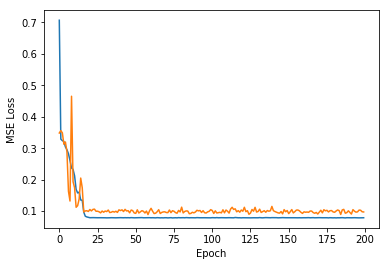

In [227]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_loss)), training_loss)
plt.plot(range(len(training_loss)), validation_loss)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.savefig("/private/home/dgopinath/data/seq2seq_1layer_batch64.svg", format='svg')

In [11]:
with open("/private/home/dgopinath/data/seq2seq_losses.csv", "w") as f:
    f.write(f"Epoch,Training_Loss,Validation_Loss\n")
    for num, (t_loss, v_loss) in enumerate(zip(training_loss, validation_loss)):
        f.write(f"{num},{t_loss},{v_loss}\n")
    

In [231]:
def get_tensor_data(tensor_struct):
    if isinstance(tensor_struct, np.ndarray):
        return tensor_struct

    elif isinstance(tensor_struct, list) or isinstance(tensor_struct, tuple):
        return np.array(tensor_struct)

    elif torch.is_tensor(tensor_struct):
        if tensor_struct.device.type == 'cuda':
            data_np = tensor_struct.data.cpu().numpy()
        else:
            data_np = tensor_struct.data.numpy()
        return data_np

    return None

In [232]:
def positions_global_from_base(rotations_joint_wrt_base, positions_joint_wrt_base):
    """
    At each time t, for each j in J:  P_j^(global) = R_base * P_j^(base)  + P_base
    :param anim:
    :return:
    """
    
    positions_base = positions_joint_wrt_base[:, 0]
    rotations_base_transforms = rotations_joint_wrt_base.transforms()[:, 0]
    T, J = positions_joint_wrt_base.shape[0], positions_joint_wrt_base.shape[1]
    positions_global = np.zeros((T, J, positions_joint_wrt_base.shape[2]))

    for t in range(T):
        positions_global[t, 0] = positions_base[t]  # simply copy base joint position
        for j in range(1, J):
            positions_global[t,j] = np.matmul(rotations_base_transforms[t], positions_joint_wrt_base[t,j]) + \
                positions_base[t]
            pass
    return positions_global

In [233]:
def upsample_motion_sequence(T, current_hertz, desired_hertz, joint_rotations, joint_positions):
    upsample_rate = int(desired_hertz / current_hertz)
    T_upsampled = T * upsample_rate
    J_p, J_r = joint_positions.shape[1], joint_rotations.shape[1]
    num_position_coordinates, num_rotation_coordinates = joint_positions.shape[2], joint_rotations.shape[2]


    joint_rotations_upsampled = np.zeros(shape=(T_upsampled, J_r, num_rotation_coordinates))
    joint_positions_upsampled = np.zeros(shape=(T_upsampled, J_p, num_position_coordinates))

    for t in range(T):

        t_upsampled = t * upsample_rate
        joint_rotations_upsampled[t_upsampled] = joint_rotations[t]
        joint_positions_upsampled[t_upsampled] = joint_positions[t]

        if (t + 1) < T:
            interpolated_rot_increment = (joint_rotations[t + 1] - joint_rotations[t]) / upsample_rate
            interpolated_pos_increment = (joint_positions[t + 1] - joint_positions[t]) / upsample_rate
            for i in range(1, upsample_rate):
                joint_rotations_upsampled[t_upsampled + i] = joint_rotations[t] + i * interpolated_rot_increment
                joint_positions_upsampled[t_upsampled + i] = joint_positions[t] + i * interpolated_pos_increment

            pass

    return joint_rotations_upsampled, joint_positions_upsampled

    
def decompose_axis_angles(axis_angles):
    """
    Input dimensions: T x J x num-coordinates
    Output dimensions:
        angles: T x J
        axes: T x J x num-coords
    """

    angles = np.linalg.norm(get_tensor_data(axis_angles), axis=2)
    axes = np.zeros_like(axis_angles)

    for t in range(axis_angles.shape[0]):  # traverse through time/datapoints
        for j in range(axis_angles.shape[1]):  # traverse through joints
            if angles[t, j] < 1e-5:
                axes[t, j, :] = [1, 0, 0]
            else:
                axes[t, j, :] = axis_angles[t, j, :] / angles[t, j]
    return angles, axes

In [234]:
class Character():
    """Defines character profile and metadata"""

    def __init__(self, id, orients=None, offsets=None, parents=None):

        self.id = id

        self.orients = orients
        self.offsets = offsets
        self.parents = parents


        self.J_p = 0
        self.J_r = 0
        self.num_rotation_coordinates = 3
        self.num_position_coordinates = 3




    #### Setters ####
    def update_metadata(self, anim):
        self.set_orients(anim.orients)
        self.set_offsets(anim.offsets)
        self.set_parents(anim.parents)


    def set_orients(self, orients):
        self.orients = orients


    def set_offsets(self, offsets):
        self.offsets = offsets


    def set_parents(self, parents):
        self.parents = parents



    def set_joint_information(self, positions, rotations):

        self.J_p = positions.shape[2]
        self.num_position_coordinates = positions.shape[3]

        self.J_r = rotations.shape[2]
        self.num_rotation_coordinates = rotations.shape[3]

In [262]:
enc = LSTMEncoder(NUM_PREDICTIONS, HIDDEN_DIM)
dec = LSTMDecoder(NUM_PREDICTIONS, HIDDEN_DIM, NUM_PREDICTIONS)
loaded_model = Seq2Seq(enc, dec).to('cuda')
loaded_model.load_state_dict(torch.load("/private/home/dgopinath/data/seq2seq/models/100.model"))
loaded_model.eval()
loaded_model.double()

outputs, inputs = generate(loaded_model, dataset["test"])
# source_character = Character('source')
# T = len(joint_rotations)



In [263]:
def upsample(outputs):
    T = outputs.shape[1]
    upsampled_sequences = []
    for seq_idx in range(outputs.shape[0]):
        rotations = outputs[seq_idx, :, 0:int(NUM_PREDICTIONS/2)].reshape(T, -1, 3)
        positions = outputs[seq_idx, :, int(NUM_PREDICTIONS/2): NUM_PREDICTIONS].reshape(T, -1, 3)
        rotations_wrt_base, positions_wrt_base = upsample_motion_sequence(T, 30, 120, rotations, positions)
        joint_rotations_angles, joint_rotations_axis = decompose_axis_angles(rotations_wrt_base)
        joint_rotations_quats = Quaternions.from_angle_axis(joint_rotations_angles, joint_rotations_axis)
        upsampled_sequences.append((joint_rotations_quats, positions_wrt_base))
    return upsampled_sequences

In [284]:
def globalize(outputs, upsampled_sequences):
    global_sequences = []
    for seq_idx in range(outputs.shape[0]):
        global_sequences.append(positions_global_from_base(*upsampled_sequences[seq_idx]))
    return global_sequences

In [294]:
def save_bvh(globalized, upsampled, idx, filepath, input_file=BASE_PATH + "/sinusoidal/source/90_90.bvh"):
    source_character = Character('source')
    anim, _, _ = BVH.load(input_file)
    source_character.update_metadata(anim)
    input_anim = Animation.Animation(upsampled[idx][0], globalized[idx], source_character.orients, source_character.offsets, source_character.parents)
    BVH.save(filepath, input_anim)

In [288]:
upsampled = upsample(inputs)
globalized = globalize(inputs, upsampled)
save_bvh(globalized, upsampled, 1, "/private/home/dgopinath/data/seq2seq/samples/1.bvh")

In [290]:
upsampled[0][1].shape

(600, 4, 3)

In [241]:
inputs[0][0][:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        , -3.        ,  6.        ,  5.        ,
        0.        ,  5.        ,  0.        , -5.        ,  5.        ,
        0.        , -5.67485316,  7.92311019,  0.        ])

In [242]:
mod_inputs[0][0]

array([[-3.        ,  6.        ,  5.        ],
       [-3.        , 11.        ,  5.        ],
       [-8.        , 11.        ,  5.        ],
       [-8.67485316, 13.92311019,  5.        ]])

In [302]:
anim, _, frametime = BVH.load(BASE_PATH + "/sinusoidal/source/90_90.bvh")
joint_rotations_root, joint_positions_root = positions_wrt_base(anim)
_, input_data, _, _ = extract_sequences(joint_rotations_root[1], joint_positions_root, frametime)

In [303]:
o, i = generate(loaded_model, np.array([input_data[0]]))

In [304]:
upsampled = upsample(o)
globalized = globalize(o, upsampled)
save_bvh(globalized, upsampled, 0, "/private/home/dgopinath/data/seq2seq/samples/output_90_90.bvh", input_file=BASE_PATH + "/sinusoidal/source/90_90.bvh")

In [305]:
output_anim, _, _ = BVH.load("/private/home/dgopinath/data/seq2seq/samples/output_90_90.bvh")

In [306]:
anim.positions[2]

array([[-3.,  6.,  5.],
       [ 0.,  5.,  0.],
       [-5.,  0.,  0.],
       [ 0.,  3.,  0.]])

In [307]:
output_anim.positions[3]

array([[-1.508132,  2.988158,  2.493383],
       [ 0.      ,  5.      ,  0.      ],
       [-5.      ,  0.      ,  0.      ],
       [ 0.      ,  3.      ,  0.      ]])

In [309]:
o[0][1]

array([ 3.8746748e-02, -8.5774055e-03, -6.3152681e-03, -3.9731123e-02,
        1.0798303e-02,  1.4542969e-03,  7.6455675e-02,  1.9589721e-03,
        5.4101890e-01,  6.0611557e-02,  8.2202367e-03,  5.5778843e-01,
       -3.0162637e+00,  5.9763150e+00,  4.9867654e+00,  4.5793336e-02,
        4.9385819e+00,  8.8929925e-03, -4.9574056e+00,  4.9799585e+00,
       -1.2611205e-02, -5.3333430e+00,  7.5692821e+00,  1.2127520e-01],
      dtype=float32)